# Project: 멋진 작사가 만들기
- 데이터셋을 학습하여 새로운 문장을 생성한다.

## 라이브러리 불러오기

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import re

## 데이터 읽어오기

In [16]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 

txt_list = glob.glob(txt_file_path)

raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


## 데이터 정제 및 토큰화

In [17]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 모두 소문자로 변환하고 앞뒤 공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 해당 특수문자 앞뒤에 공백 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러 개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 알파벳, 해당 특수문자 제외하고는 공백으로 바꾸기
    sentence = sentence.strip() # 앞뒤 공백 제거
    sentence = '<start> ' + sentence + ' <end>' # 문장 시작과 끝에 각각 <start>와 <end> 붙이기
    return sentence

In [41]:
print(preprocess_sentence("This @_is ;;;sample        sentence.")) # 필터링 잘되는지 확인

<start> this is sample sentence . <end>


In [18]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20) # maxlen보다 짧은 문장은 뒤에 패딩 추가
    
    print(tensor,tokenizer)
    return tensor, tokenizer

In [19]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: # 길이가 0인 문장은 생략
        continue
    if sentence[-1] == ":": # 문장의 끝이 ":"인 문장은 생략
        continue
        
    corpus.append(preprocess_sentence(sentence))

In [20]:
tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f79fcf77520>


In [21]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]

In [22]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2,
                                                            shuffle=True, random_state=42)

## 모델 구축 및 학습

In [34]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [35]:
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [36]:
early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

과적합을 방지하고자 early stopping을 적용하였다.

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, 
    reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, dec_train, epochs=30, validation_data=(enc_val, dec_val), callbacks=[early_stopping])

Epoch 1/30
4394/4394 [==============================] - 159s 35ms/step - loss: 2.4812 - val_loss: 2.2685
Epoch 2/30
4394/4394 [==============================] - 154s 35ms/step - loss: 2.1624 - val_loss: 2.1148
Epoch 3/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.9753 - val_loss: 2.0177
Epoch 4/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.8041 - val_loss: 1.9568
Epoch 5/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.6477 - val_loss: 1.9208
Epoch 6/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.5060 - val_loss: 1.8986
Epoch 7/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.3796 - val_loss: 1.8908
Epoch 8/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.2672 - val_loss: 1.8882
Epoch 9/30
4394/4394 [==============================] - 154s 35ms/step - loss: 1.1693 - val_loss: 1.9013
Epoch 10/30
4394/4394 [==============================] 

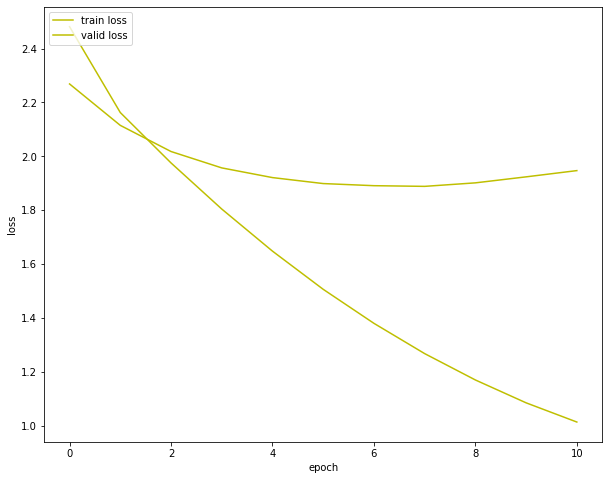

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(history.history['loss'], 'y', label = 'train loss')
ax.plot(history.history['val_loss'], 'y', label = 'valid loss')


ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax.legend(loc='upper left')

plt.show()

valid loss가 오르기 시작했고, 더 오르기 전에 학습을 중단하였다. train loss는 꾸준히 떨어진 걸로 보아 학습이 잘된 것을 알 수 있다.

In [39]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): 

    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]


    while True:
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len: 
            break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [49]:
generate_text(model, tokenizer, init_sentence="<start> i hope", max_len=20)

'<start> i hope that you can see , <end> '

해석 가능한 문장이 생성된 것을 확인할 수 있다

# 회고

- `maxlen`을 `None`으로 해봤는데, 소요시간이 한 epoch 당 30분 이상 소요되었다. loss는 빠르게 떨어졌지만, 낮은 loss에 비해 생성된 결과값은 불만족스러웠다. 학습이 덜 되어서 그런 것 같은데, epoch 당 소요 시간이 매우 길어서 더 길게 학습을 시킬 수는 없었다.
- `LSTM` 대신 `RNN`을 사용해보았다. loss가 2.3대에서 더 떨어지지 않았다.
- 같은 조건에서 `LSTM`으로 돌린 결과 loss가 1.9대까지 떨어졌다.
- `LSTM`이나 `RNN`으로 분류 태스크만 해봤는데 생성을 처음 해봐서 재밌었다. 나중에 다른 생성모델을 사용해서도 문장 생성 태스크를 한 번 해보고 싶다.